In [57]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [58]:
pwd

'/home/shakyafernando/projects/monocular-depth-submodules/depth-anything-v2/notebooks'

In [77]:
# Specify the path to the depth map you want to analyze
depth_map_directory = '../data/diego/set1/depth-maps/bream-oyster/'
depth_map_filename = 'bream_oyster_frame_000001_pred04.png'  # depth map filename
depth_map_path = os.path.join(depth_map_directory, depth_map_filename)

In [78]:
# CSV file path
csv_file_path = '../data/diego/set1/csv/results_bream_oyster.csv'


Depth map loaded successfully from ../data/diego/set1/depth-maps/bream-oyster/bream_oyster_frame_000001_pred04.png.


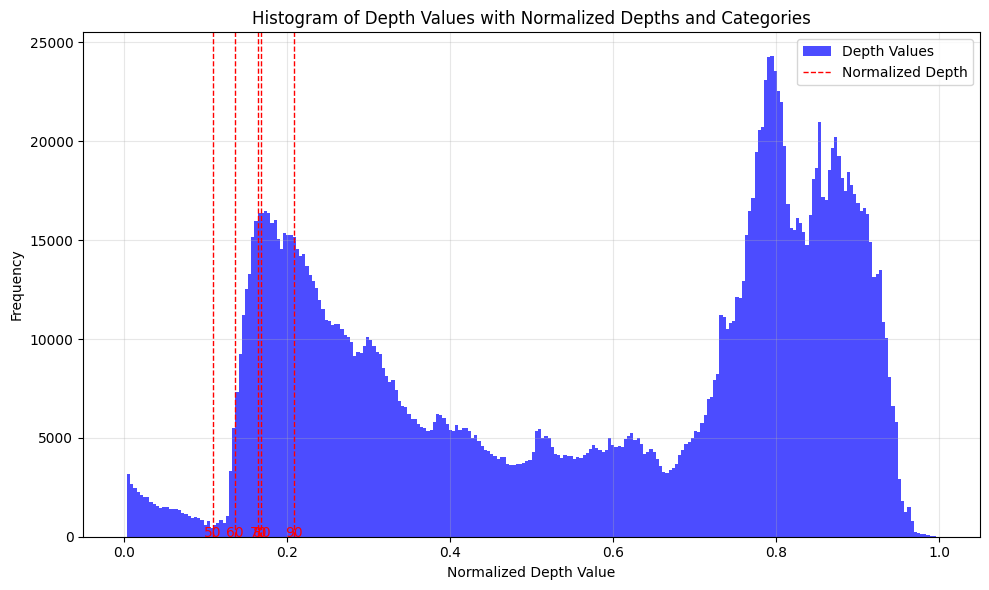

In [79]:
# Load depth map
depth_map = cv2.imread(depth_map_path, cv2.IMREAD_UNCHANGED)
if depth_map is None:
    print(f"Failed to load depth map at {depth_map_path}.")
else:
    print(f"Depth map loaded successfully from {depth_map_path}.")

    # Normalize depth map if necessary
    if depth_map.dtype == np.uint8:
        depth_values = depth_map.flatten() / 255.0
    elif depth_map.dtype == np.uint16:
        depth_values = depth_map.flatten() / 65535.0
    else:
        depth_values = depth_map.flatten()

    # Remove zero values if desired
    depth_values_nonzero = depth_values[depth_values > 0]

    # Load CSV file
    df = pd.read_csv(csv_file_path)

    # Filter rows where 'depth_map_file' equals the selected depth map filename
    matching_rows = df[df['depth_map_file'] == depth_map_filename]

    # Get 'normalized_depth' values from matching rows
    normalized_depths = matching_rows['normalized_depth'].values
    category_names = matching_rows['category_name'].values

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(depth_values_nonzero, bins=256, range=(0, 1), color='blue', alpha=0.7, label='Depth Values')

    # Plot 'normalized_depth' values on histogram in red and annotate with 'category_name'
    if len(normalized_depths) > 0:
        for idx, (nd, category_name) in enumerate(zip(normalized_depths, category_names)):
            # Plot vertical line
            plt.axvline(x=nd, color='red', linestyle='dashed', linewidth=1, label='Normalized Depth' if idx == 0 else None)
            # Add category name annotation below the line
            plt.text(nd, -5, category_name, color='red', fontsize=10, ha='center')
    else:
        print(f"No matching 'normalized_depth' values found in CSV for {depth_map_filename}.")

    plt.title('Histogram of Depth Values with Normalized Depths and Categories')
    plt.xlabel('Normalized Depth Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [80]:
# Metric depths for each category_name
category_metric_depths = {
    50: 0.5, 
    60: 0.6,
    70: 0.7,
    80: 0.8,
    90: 0.9,
}

In [81]:
# Initialize lists to hold valid data
metric_depths = []
valid_normalized_depths = []
valid_category_names = []

In [82]:
# Match categories with known metric depths
for nd, category_name in zip(normalized_depths, category_names):
    category_name_str = str(category_name) # Convert to string
    if category_name in category_metric_depths:
        metric_depth = category_metric_depths[category_name]
        metric_depths.append(metric_depth)
        valid_normalized_depths.append(nd)
        valid_category_names.append(category_name)
    else:
        print(f"No metric depth defined for category '{category_name}'.")

Linear regression result: metric_depth = 4.1620 * normalized_depth + 0.0454
R-squared: 0.9605


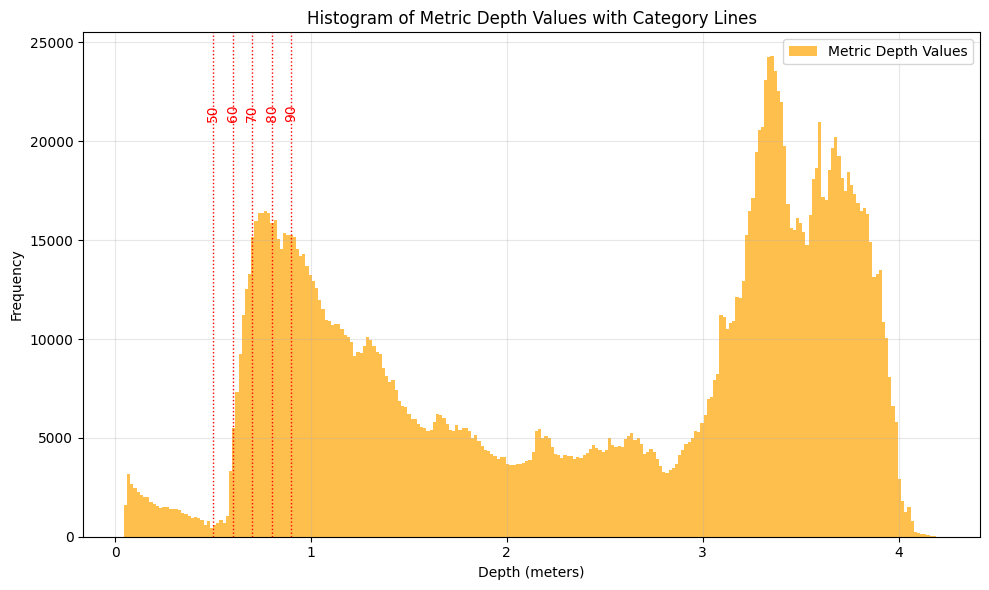

In [83]:
# Check two or more points
if len(valid_normalized_depths) >= 2:
    # Convert lists to numpy arrays
    valid_normalized_depths = np.array(valid_normalized_depths)
    metric_depths = np.array(metric_depths)

    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(valid_normalized_depths, metric_depths)

    print(f"Linear regression result: metric_depth = {slope:.4f} * normalized_depth + {intercept:.4f}")
    print(f"R-squared: {r_value**2:.4f}")

    # Convert the entire depth map to metric depths
    depth_map_metric = slope * depth_values + intercept

    # Reshape back to the original depth map shape
    depth_map_metric = depth_map_metric.reshape(depth_map.shape)

    # Plot the metric depth map histogram with vertical lines
    plt.figure(figsize=(10, 6))

    # Obtain histogram data
    counts, bins, patches = plt.hist(depth_map_metric.flatten(), bins=256, color='orange', alpha=0.7, label='Metric Depth Values')

    plt.title('Histogram of Metric Depth Values with Category Lines')
    plt.xlabel('Depth (meters)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Get the maximum count from the histogram to position the annotations
    max_count = counts.max()

    # Plot categories
    for md, category_name in zip(metric_depths, valid_category_names):
        # Plot the vertical line
        plt.axvline(x=md, color='red', linestyle='dotted', linewidth=1)
        
        # Add the category name as text above the line
        plt.text(md, max_count * 0.9, str(category_name), rotation=90, color='red', va='top', ha='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough reference points to perform linear regression.")

Linear regression result: metric_depth = 4.1620 * normalized_depth + 0.0454
R-squared: 0.9605
Metric Depth Map Statistics:
Min: 0.0454 meters
Max: 4.2074 meters


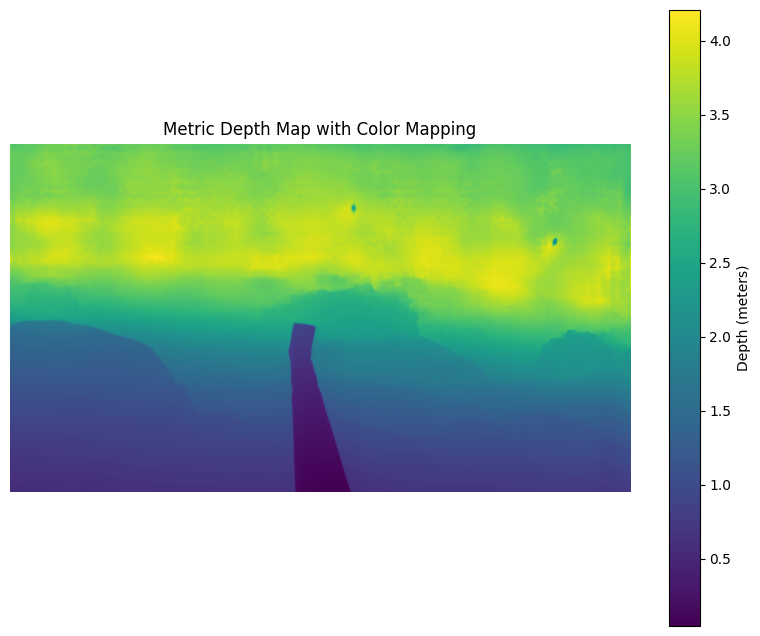

Metric depth map image saved to metric_depth_map.png.
Metric depth map data saved as 'metric_depth_map.npy'.


In [84]:
# Check points
if len(valid_normalized_depths) >= 2:
    # Convert lists to numpy arrays
    valid_normalized_depths = np.array(valid_normalized_depths)
    metric_depths = np.array(metric_depths)

    # Perform linear regression
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(valid_normalized_depths, metric_depths)

    print(f"Linear regression result: metric_depth = {slope:.4f} * normalized_depth + {intercept:.4f}")
    print(f"R-squared: {r_value**2:.4f}")

    # Convert the entire depth map to metric depths
    depth_map_metric = slope * depth_values + intercept

    # Reshape back to the original depth map shape
    depth_map_metric = depth_map_metric.reshape(depth_map.shape)

    print(f"Metric Depth Map Statistics:\nMin: {depth_map_metric.min():.4f} meters\nMax: {depth_map_metric.max():.4f} meters")

    # Visualize the metric depth map with color mapping
    plt.figure(figsize=(10, 8))
    plt.imshow(depth_map_metric, cmap='viridis')
    plt.colorbar(label='Depth (meters)')
    plt.title('Metric Depth Map with Color Mapping')
    plt.axis('off')
    plt.show()

    # Scaling for visualization (0-255)
    min_depth = depth_map_metric.min()
    max_depth = depth_map_metric.max()
    depth_map_scaled = (depth_map_metric - min_depth) / (max_depth - min_depth)  # Normalize to 0-1
    depth_map_scaled = (depth_map_scaled * 255).astype(np.uint8)  # Scale to 0-255 and convert to uint8

    # Save the depth map as an image
    output_image_path = 'metric_depth_map.png'
    # cv2.imwrite(output_image_path, depth_map_scaled)
    print(f"Metric depth map image saved to {output_image_path}.")

    # Save the metric depth map data for future use
    # np.save('metric_depth_map.npy', depth_map_metric)
    print("Metric depth map data saved as 'metric_depth_map.npy'.")

else:
    print("Not enough reference points to perform linear regression.")
